In [1]:
import numpy as np
from sklearn import preprocessing, neighbors
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.layers import Flatten, LSTM, Input, Embedding
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
#from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [60]:
path =r'D:\Py scripts\Sad Analysis\Own dataset'
targets = ['Solving', 'Relaxed']
#targets = ['Solving', 'Relaxed', 'Laugh']

In [61]:
targets

['Solving', 'Relaxed']

In [62]:
def divide_chunks(l, n): 
# looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

In [63]:
# get data file names
seg_dim = 7500
def segments(tag, seg_dim):
    filenames = glob.glob("{}\{}".format(path, tag) + "/*.csv")
    tag_df = pd.DataFrame()
    eeg_data = []
    for filename in filenames:
        tmp = pd.DataFrame()
        df = pd.read_csv(filename)
        segmented_eeg = list(divide_chunks(list(df['eegRawValue']), seg_dim))
        tmp['EEG'] = segmented_eeg
        tmp['tag_label'] = tag
        tmp['eeglen'] = tmp.EEG.apply(lambda x: len(x))
        tmp = tmp.query('eeglen == @seg_dim')
        eeg_data.append(tmp)
    #tag_df = pd.concat(eeg_data)
    return pd.concat(eeg_data)

In [64]:
train = []
for tag in targets:
    train.append(segments(tag, seg_dim))

In [65]:
train = pd.concat(train)
#train.to_csv("Recently_prepared_train2.csv", index = False)

In [66]:
train.columns

Index(['EEG', 'tag_label', 'eeglen'], dtype='object')

In [67]:
train.tag_label.value_counts()

Solving    108
Relaxed     89
Name: tag_label, dtype: int64

In [68]:
def replace(tag):
    if tag == 'Relaxed':
        return 0
    if tag == 'Solving':
        return 1
    if tag == 'Laugh':
        return 2
    # Relaxed -> 0

train['tag'] = train.tag_label.apply(replace)

In [69]:
X = np.array(list(train.EEG))
Y = train.tag.values
X = X.reshape(len(X), seg_dim, 1)
Y = pd.get_dummies(train.tag).values

In [70]:
X_train,X_test,y_train,y_test = train_test_split(X, Y,test_size = 0.20)

In [71]:
from keras.layers import Layer
import keras.backend as K

In [72]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [75]:
inputs1=Input(shape=(7500,1))
x1=LSTM(64,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(inputs1)
att_out=attention()(x1)

x2 = Dense(500,activation='relu')(att_out)
x2 = Dense(200,activation='relu')(x2)
x2 = Dense(100,activation='relu')(x2)

outputs1=Dense(2,activation='softmax')(x2)
model1=Model(inputs1,outputs1)
model1.compile(loss = 'categorical_crossentropy', optimizer='Adam',metrics = ['accuracy'])

In [76]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 7500, 1)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 7500, 64)          16896     
_________________________________________________________________
attention_8 (attention)      (None, 64)                7564      
_________________________________________________________________
dense_18 (Dense)             (None, 500)               32500     
_________________________________________________________________
dense_19 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_20 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 202       
Total para

In [77]:
#Fitting the NN model 64 units; 2 classes
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model1.fit(X_train, y_train, epochs= 20, shuffle = True, callbacks=[es], 
                     validation_data=[X_test,y_test])

Train on 157 samples, validate on 40 samples
Epoch 1/20
157/157 [==============================] - 211s 1s/step - loss: 0.6943 - acc: 0.5478 - val_loss: 0.6786 - val_acc: 0.5250
Epoch 2/20
157/157 [==============================] - 189s 1s/step - loss: 0.6828 - acc: 0.5478 - val_loss: 0.6587 - val_acc: 0.5250
Epoch 3/20
157/157 [==============================] - 191s 1s/step - loss: 0.6867 - acc: 0.5478 - val_loss: 0.6441 - val_acc: 0.7250
Epoch 4/20
157/157 [==============================] - 199s 1s/step - loss: 0.6895 - acc: 0.5924 - val_loss: 0.6356 - val_acc: 0.7750
Epoch 5/20
157/157 [==============================] - 184s 1s/step - loss: 0.6727 - acc: 0.6306 - val_loss: 0.6062 - val_acc: 0.7500
Epoch 6/20
157/157 [==============================] - 190s 1s/step - loss: 0.6771 - acc: 0.6051 - val_loss: 0.5895 - val_acc: 0.8000
Epoch 7/20
157/157 [==============================] - 181s 1s/step - loss: 0.6821 - acc: 0.5924 - val_loss: 0.5887 - val_acc: 0.7750
Epoch 8/20
157/157 [====

In [40]:
#Fitting the NN model 64 units; 3 classes
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model1.fit(X_train, y_train, epochs= 20, shuffle = True, callbacks=[es], 
                     validation_data=[X_test,y_test])

Train on 192 samples, validate on 49 samples
Epoch 1/20
192/192 [==============================] - 75s 391ms/step - loss: 1.0735 - acc: 0.3906 - val_loss: 0.9727 - val_acc: 0.5306
Epoch 2/20
192/192 [==============================] - 75s 391ms/step - loss: 0.9978 - acc: 0.4688 - val_loss: 0.8845 - val_acc: 0.5510
Epoch 3/20
192/192 [==============================] - 75s 390ms/step - loss: 0.9234 - acc: 0.5104 - val_loss: 0.8352 - val_acc: 0.4898
Epoch 4/20
192/192 [==============================] - 79s 413ms/step - loss: 0.8912 - acc: 0.4844 - val_loss: 0.8111 - val_acc: 0.5714
Epoch 5/20
192/192 [==============================] - 75s 389ms/step - loss: 0.8599 - acc: 0.5573 - val_loss: 0.8283 - val_acc: 0.4898
Epoch 6/20
192/192 [==============================] - 74s 386ms/step - loss: 0.8596 - acc: 0.5156 - val_loss: 0.8506 - val_acc: 0.5918
Epoch 7/20
192/192 [==============================] - 74s 385ms/step - loss: 0.8447 - acc: 0.5833 - val_loss: 0.8518 - val_acc: 0.5102
Epoch 8/20

In [ ]:
model.summary()

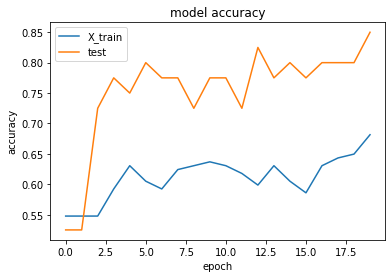

In [83]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['X_train', 'test'], loc='upper left')
plt.show()

In [79]:
Y_p = model1.predict(X_test)

In [59]:
# This is for 3 emotional states -> Solving a puzzle within a timeframe (108 samples), relaxed state (89), laugh (49)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
print('Accuracy:', accuracy_score(y_test.argmax(axis=1), Y_p.argmax(axis=1)))
print('F1 score:', f1_score(y_test.argmax(axis=1), Y_p.argmax(axis=1),average='weighted'))
print('Recall:', recall_score(y_test.argmax(axis=1), Y_p.argmax(axis=1), average='weighted'))
print('Precision_score:', precision_score(y_test.argmax(axis=1), Y_p.argmax(axis=1), average='weighted'))

Accuracy: 0.5714285714285714
F1 score: 0.5648194237044412
Recall: 0.5714285714285714
Precision_score: 0.575117496391269


In [80]:
# This is for  emotional states -> Solving a puzzle within a timeframe (108 samples), relaxed state (89)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
print('Accuracy:', accuracy_score(y_test.argmax(axis=1), Y_p.argmax(axis=1)))
print('F1 score:', f1_score(y_test.argmax(axis=1), Y_p.argmax(axis=1),average='weighted'))
print('Recall:', recall_score(y_test.argmax(axis=1), Y_p.argmax(axis=1), average='weighted'))
print('Precision_score:', precision_score(y_test.argmax(axis=1), Y_p.argmax(axis=1), average='weighted'))

Accuracy: 0.85
F1 score: 0.85
Recall: 0.85
Precision_score: 0.8542606516290727


In [81]:
Y_p.argmax(axis=1)

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

In [82]:
y_test.argmax(axis=1)

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1], dtype=int64)